## Importing Libraries and Modules

In this cell, we import necessary libraries and modules required for our OCR project. This includes libraries for numerical operations, image processing, machine learning, and plotting.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState  # Correct import for RandomState
import os
import random


# Ensure correct GPU order for TensorFlow
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# Additional libraries for file handling, image processing, and machine learning
import string
from shutil import copyfile, rmtree
import re
import cv2
from PIL import Image, ImageDraw
import glob
from keras.callbacks import EarlyStopping

# Running the functions_nb.ipynb to import custom functions
%run functions_nb.ipynb


## Defining Paths and Initializing Variables

In this cell, we define the paths for saving the model and data, and initialize necessary variables for our project. This includes setting the batch size, image dimensions, and random state.


In [2]:
# Define paths for saving the model and data
save_path = "C:/Users/HP/Desktop/CODES"
path = "C:/Users/HP/Desktop/CODES/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data"
model_name = "OCR_IFNENIT_verl"

# Initialize random state
prng = RandomState(32)

# Set batch size and image dimensions
batch_size = 64
imgh = 100
imgw = 300


In [3]:
sets = ['set_a', 'set_b', 'set_c', 'set_d']

names = []
for set in sets:
    PATH = path + '/' + set + '/' + 'tif'
    names.extend([dp + "/" + f for dp, dn, filenames in os.walk(PATH) for f in filenames if re.search('tif', f)])

# Split the data into training and testing sets
train_data = []
test_data = []
for name in names:
    if name.split("/")[2] == 'set_d':
        test_data.append(name)
    else:
        train_data.append(name)


## Preparing the Data

In this cell, we prepare the data by shuffling, splitting into training and validation sets, and extracting the lexicon and classes. We also create necessary directories for saving the model.


In [4]:
# Remove and recreate the model save directory
try:
    rmtree(save_path + "/" + model_name)
except:
    pass

os.mkdir(save_path + "/" + model_name)

# Get all training images
train = []
for set in sets[:-1]:  # exclude set 'd'
    PATH = path + '/' + set + '/' + 'tif'
    train.extend([dp + "/" + f for dp, dn, filenames in os.walk(PATH) for f in filenames if re.search('tif', f)])

# Shuffle the training data
prng.shuffle(train)

# Extract lexicon and create class mappings
lexicon = get_lexicon_2(train)
classes = {j: i for i, j in enumerate(lexicon)}
inve_classes = {v: k for k, v in classes.items()}

# Split the data into training and validation sets
length = len(train)
train, val = train[:int(length * 0.9)], train[int(length * 0.9):]

# Make sure that train and val are not empty
if not train or not val:
    print("Error: train or val is empty")
    exit()

# Get the lengths of the words in the training set
lenghts = get_lengths(train)

# Make sure that lenghts is not empty
if not lenghts:
    print("Error: lenghts is empty")
    exit()

# Get the maximum length of the words in the training set
max_len = max(lenghts.values())

# Initialize data reading object
objet = Readf(classes=classes)


## Building and Compiling the Model

In this cell, we build the CNN-LSTM model for OCR using the CRNN class, compile it with the CTC loss function, and prepare the training and validation generators.


In [5]:
# Set image dimensions and output size
img_w, img_h = 300, 100
output_size = len(classes) + 1

# Create the CRNN model
crnn = CRNN(img_w, img_h, output_size, max_len)
model = crnn.model

# Compile the model with CTC loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

# Prepare training and validation generators
train_generator = objet.run_generator(train)
val_generator = objet.run_generator(test_data)

# Calculate steps per epoch for training and validation
train_steps = len(train) // batch_size
val_steps = len(val) // batch_size + 1





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 100, 300)]           0         []                            
                                                                                                  
 lambda (Lambda)             (None, 100, 300, 1)          0         ['the_input[0][0]']           
                                                                                                  
 conv1 (Conv2D)              (None, 100, 300, 16)         160       ['lambda[0][0]']              
                                                                                                  
 pool1 (MaxPooling2D)        (None, 50, 150, 16)          0         ['conv1[0][0]']               
                                                                                            

## Training the Model

In this cell, we train the model using the training generator and validate it using the validation generator. We also plot the training history to visualize the training and validation losses.


In [6]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

train_generator = objet.run_generator(train)
val_generator = objet.run_generator(val)

train_steps = len(train) // batch_size
val_steps = len(val) // batch_size + 1

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=20)

# Create empty arrays to store the evaluation results
losses = []

# Iterate over the validation generator and calculate loss for each batch
for i in range(val_steps):
    inputs, targets = next(val_generator)
    loss = model.evaluate(inputs, targets, verbose=0)
    losses.append(loss)

# Calculate the average validation loss
validation_loss = np.mean(losses)

Epoch 1/20


277/277 [==============================] - 270s 963ms/step - loss: 35.6432 - ctc_loss: 35.6432 - val_loss: 31.4349 - val_ctc_loss: 31.4349
Epoch 2/20
277/277 [==============================] - 253s 916ms/step - loss: 28.6261 - ctc_loss: 28.6261 - val_loss: 26.0803 - val_ctc_loss: 26.0803
Epoch 3/20
277/277 [==============================] - 275s 994ms/step - loss: 23.7657 - ctc_loss: 23.7657 - val_loss: 22.1499 - val_ctc_loss: 22.1499
Epoch 4/20
277/277 [==============================] - 259s 935ms/step - loss: 20.2847 - ctc_loss: 20.2847 - val_loss: 19.8645 - val_ctc_loss: 19.8645
Epoch 5/20
277/277 [==============================] - 253s 913ms/step - loss: 17.6801 - ctc_loss: 17.6801 - val_loss: 17.6213 - val_ctc_loss: 17.6213
Epoch 6/20
277/277 [==============================] - 269s 972ms/step - loss: 15.5623 - ctc_loss: 15.5623 - val_loss: 16.0702 - val_ctc_loss: 16.0702
Epoch 7/20
277/277 [==============================] - 272s 982ms/step - loss: 13.8240 - ctc_loss: 

## Plotting Training History

In this cell, we define a function to plot the training history, showing the loss curves for both training and validation sets.


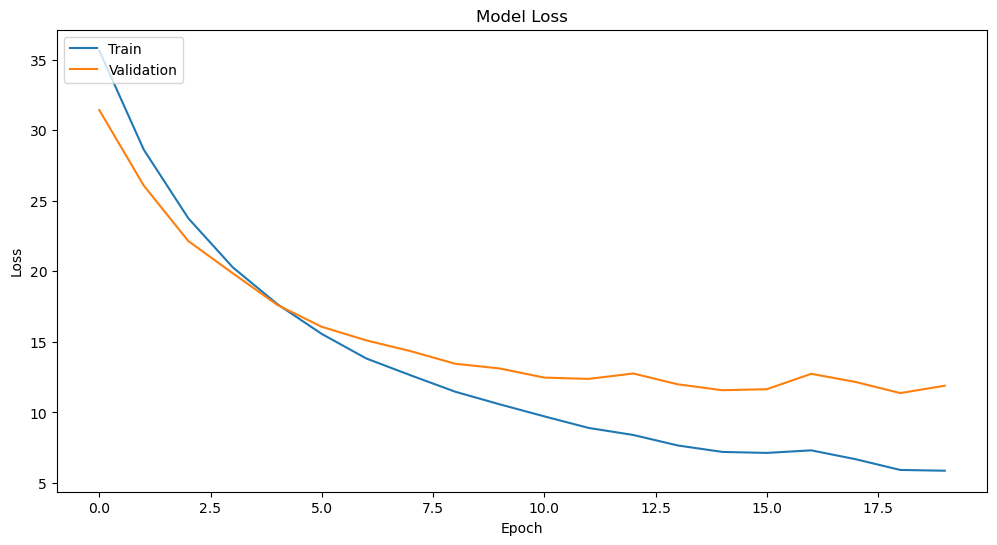

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)


## Decodage

## Defining the `num_to_label` Function

In this cell, we define the `num_to_label` function to convert numeric labels back to characters.


In [8]:
def num_to_label(num, inv_classes):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            char = inv_classes.get(ch)
            if char is not None:  # Check if the character exists in the mapping
                ret += char
    return ret


## Importing Necessary Libraries


In this cell, we import necessary libraries for beam search decoding using TensorFlow.


In [9]:
import numpy as np
import tensorflow as tf
from keras import backend as K


## Making Predictions and Decoding with Word Beam Search

In this cell, we make predictions using the trained model and decode them using word beam search.   
The provided code snippet implements beam search decoding for evaluating a CRNN model on a validation dataset. Here's a breakdown of the steps:

**1. Preparing for Decoding:**

* `predictions_ctc_loss` and `predictions_probabilities` are empty lists to store the CTC loss and predicted probabilities from the model for each batch in the validation set.

**2. Batch-wise Prediction:**

* A loop iterates over the validation generator (`val_steps` times).
* For each batch (`inputs`):
    * The model predicts the CTC loss and probabilities (`batch_ctc_loss`, `batch_predictions`).
    * These predictions are appended to the respective lists (`predictions_ctc_loss` and `predictions_probabilities`).

**3. Concatenating Predictions:**

* After iterating through all batches, the predictions for CTC loss and probabilities are concatenated across batches using `np.concatenate`. This creates single arrays representing the predictions for the entire validation set.

**4. Beam Search Decoding:**

* TensorFlow's `K.ctc_decode` function performs beam search decoding on the concatenated probabilities (`predictions_probabilities`).
    * `input_length`: This is set to a constant array with shape matching the probabilities, likely indicating a fixed sequence length for all predictions.
    * `greedy=False`: Disables greedy decoding, enabling beam search for exploring multiple candidate sequences.
    * `beam_width=10`: Sets the beam width to 10, meaning the decoder considers 10 most likely candidate sequences at each step.
* `K.get_value` retrieves the decoded sequence from the TensorFlow symbolic tensor.
* A loop iterates over the decoded sequence (`decoded`):
    * `num_to_label` function (not shown) likely maps the numerical predictions back to characters using the provided `inve_classes` dictionary.
    * The converted character sequence is appended to the `decoded_words` list.

**5. Evaluation:**

* `true_words` is an empty list to store the ground truth words for the validation images.
* A loop iterates over the validation set (`val`):
    * `evaluate_word` function (not shown) likely retrieves the true word associated with the current image path.
    * The true word is appended to the `true_words` list.
* Finally, the code iterates through both `true_words` and `decoded_words` in a zip fashion, printing whether the prediction was correct or incorrect for each image.

**Overall, this code snippet demonstrates how to use beam search decoding to evaluate the performance of a CRNN model on a validation set. It compares the predicted words with the true words for each image and reports the accuracy.**


In [10]:
# Create empty arrays to store the predictions
predictions_ctc_loss = []
predictions_probabilities = []

# Iterate over the validation generator and make predictions for each batch
for i in range(val_steps):
    inputs, _ = next(val_generator)

    # Make predictions with the model
    batch_ctc_loss, batch_predictions = model.predict(inputs)

    predictions_ctc_loss.append(batch_ctc_loss)
    predictions_probabilities.append(batch_predictions)

# Concatenate the predictions for all batches
predictions_ctc_loss = np.concatenate(predictions_ctc_loss, axis=0)
predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)

# Beam search decoding using TensorFlow
decoded = K.get_value(K.ctc_decode(predictions_probabilities, input_length=np.ones(predictions_probabilities.shape[0]) * predictions_probabilities.shape[1], greedy=False, beam_width=10)[0][0])

decoded_words = []
for d in decoded:
    decoded_word = num_to_label(d, inve_classes)
    decoded_words.append(decoded_word)

true_words = []  # List to store the true words

# Iterate over the validation set
for image_path in val:
    true_word = evaluate_word(image_path)  # Get the true word for the current image
    true_words.append(true_word)

# Compare the true words with the decoded words
for true_word, decoded_word in zip(true_words, decoded_words):
    if true_word == decoded_word:
        print("Correct: ", true_word)
    else:
        print("Incorrect: True word =", true_word, ", Decoded word =", decoded_word)


2/2 [==============================] - 0s 151ms/step
Incorrect: True word = ['aaA', 'waA', 'taB', 'yaM', 'keE'] , Decoded word = taBwaEayBshMllLaaEheE
Incorrect: True word = ['naB', 'kaMllL', '-'] , Decoded word = kaBraEayBteEaaAlaBnaMllLaaEzaBwaEraA
Incorrect: True word = ['baB', 'waE', 'ghB', 'raE', 'aaA', 'raA', 'teA'] , Decoded word = haByaEaaAaaElaBnaBtoMaaElaMteE
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'maB', 'toM', 'yaM', 'raE'] , Decoded word = aaAlaBmaMnaMaaAteEaaAlaBmaMnaMwaEteE
Incorrect: True word = ['maB', 'yaM', 'daE', 'waA', 'naA'] , Decoded word = baBnaEyaBtaE
Incorrect: True word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'taB', 'toM', 'aaE', 'waA', 'yaB', 'naE'] , Decoded word = seByaMdaEyaAaaAlaBzaMllLaaEheBraE
Incorrect: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', '-', 'aaA', 'waA', 'yaA'] , Decoded word = haBaaEseBllLyaEayBbaMraEraA
Incorrect: True word = ['raA', 'baB', 'aaE', 'yaB', 'ayE', 'seB', 'yaM', 'daE', 'yaA', 'zaB', '

## Best-path decoding


The provided code snippet is almost identical to the one you explained for beam search decoding, with one key difference: it performs **best-path decoding** instead. Here's a breakdown of the relevant parts:

**Similarities:**

* The code prepares for decoding by creating lists for predictions and iterates through the validation set making predictions in batches.
* It concatenates the predictions for all batches and uses `K.ctc_decode` for decoding.
* It retrieves the decoded sequence, converts it back to characters, and compares the decoded words with the true words for evaluation.

**Difference:**

* In the `K.ctc_decode` call, the `greedy=False` argument is missing. This is because best-path decoding is essentially greedy decoding (also called argmax decoding). It selects the most likely character at each time step, resulting in a single best path through the probability matrix.

**Best-Path Decoding:**

* Best-path decoding is a simpler and faster alternative to beam search.
* It always chooses the single most probable character at each time step, leading to a faster decoding process.
* However, it might miss out on potentially better sequences with lower probabilities at some steps but a higher overall probability.

**Code Explanation:**

1. **Prediction and Concatenation:** 
    - The code predicts probabilities for each batch and concatenates them to form a single array representing the entire validation set.

2. **Best-Path Decoding:**
    - `K.ctc_decode` is used with the default arguments, which include greedy decoding (selecting the most probable character at each step).
    - The decoded sequence represents the single best path through the probability matrix.

3. **Evaluation:**
    - The decoded sequence is converted to characters and compared with the true words for each image in the validation set.

**In summary, this code snippet demonstrates how to use best-path decoding to evaluate a CRNN model on a validation set. It's a simpler and faster approach than beam search but might be less accurate.**

In [11]:

# Create empty arrays to store the predictions
predictions_ctc_loss = []
predictions_probabilities = []

# Iterate over the validation generator and make predictions for each batch
for i in range(val_steps):
    inputs, _ = next(val_generator)

    # Reshape the input images to match the expected shape of the model
    inputs['the_input'] = inputs['the_input'].reshape((-1, imgw, imgh))

    # Make predictions with the model
    batch_ctc_loss, batch_predictions = model.predict(inputs)

    predictions_ctc_loss.append(batch_ctc_loss)
    predictions_probabilities.append(batch_predictions)

# Concatenate the predictions for all batches
predictions_ctc_loss = np.concatenate(predictions_ctc_loss, axis=0)
predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)


#Best-path decoding
decoded = K.get_value(K.ctc_decode(predictions_probabilities, input_length=np.ones(predictions_probabilities.shape[0])*predictions_probabilities.shape[1], greedy=False)[0][0])

decoded_words = []
for d in decoded:
    decoded_word = num_to_label(d, inve_classes)
    decoded_words.append(decoded_word)
    

true_words = []  # List to store the true words

# Iterate over the validation set
for image_path in val:
    true_word = evaluate_word(image_path)  # Get the true word for the current image
    true_words.append(true_word)
# Compare the true words with the decoded words
for true_word, decoded_word in zip(true_words, decoded_words):
    if true_word == decoded_word:
        print("Correct: ", true_word)
    else:
        print("Incorrect: True word =", true_word, ", Decoded word =", decoded_word)  


2/2 [==============================] - 0s 146ms/step
Incorrect: True word = ['aaA', 'waA', 'taB', 'yaM', 'keE'] , Decoded word = zaAkaMaaEthBtoMteE
Incorrect: True word = ['naB', 'kaMllL', '-'] , Decoded word = waAbaMaaEraEyaMllL
Incorrect: True word = ['baB', 'waE', 'ghB', 'raE', 'aaA', 'raA', 'teA'] , Decoded word = taBbaMaaEteEaaE-aaEbaM-
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'maB', 'toM', 'yaM', 'raE'] , Decoded word = waAbaMaaEyaMllLteEyaMllLnaMyaMllLnaM
Incorrect: True word = ['maB', 'yaM', 'daE', 'waA', 'naA'] , Decoded word = zaAyaMraEyaMyaMllLteE
Incorrect: True word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'taB', 'toM', 'aaE', 'waA', 'yaB', 'naE'] , Decoded word = waAyaMaaElaBraEbaMyaE
Incorrect: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', '-', 'aaA', 'waA', 'yaA'] , Decoded word = taBkaMraEtaBbaMraE
Incorrect: True word = ['raA', 'baB', 'aaE', 'yaB', 'ayE', 'seB', 'yaM', 'daE', 'yaA', 'zaB', 'aaE', 'heB', 'raE'] , Decoded word = zaA